In [0]:
# Importing Libraries

In [0]:
import pandas as pd
import numpy as np

In [0]:
from google.colab import drive
drive.mount("/content/drive/")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### Data

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename =f'/content/drive/My Drive/Colab Notebooks/HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename =f'/content/drive/My Drive/Colab Notebooks/HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [0]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [0]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 32
n_hidden = 16

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [0]:
X_train.shape

(7352, 128, 9)

In [0]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

# Model-1 with 16 LSTM cells, Dropout rate=0.2 and 30 epochs

In [0]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(16, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.2))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 16)                1664      
_________________________________________________________________
dropout_3 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 1,766
Trainable params: 1,766
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
# Training the model

model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 45s 6ms/step - loss: 1.3948 - acc: 0.4199 - val_loss: 1.2082 - val_acc: 0.5008
Epoch 2/30
7352/7352 [==============================] - 40s 5ms/step - loss: 1.0421 - acc: 0.5609 - val_loss: 1.2011 - val_acc: 0.4947
Epoch 3/30
7352/7352 [==============================] - 41s 6ms/step - loss: 0.9104 - acc: 0.6340 - val_loss: 0.9751 - val_acc: 0.6597
Epoch 4/30
7352/7352 [==============================] - 42s 6ms/step - loss: 0.7810 - acc: 0.6885 - val_loss: 0.9200 - val_acc: 0.5704
Epoch 5/30
7352/7352 [==============================] - 42s 6ms/step - loss: 0.6623 - acc: 0.7205 - val_loss: 0.7262 - val_acc: 0.7072
Epoch 6/30
7352/7352 [==============================] - 42s 6ms/step - loss: 0.5569 - acc: 0.7692 - val_loss: 0.6556 - val_acc: 0.7302
Epoch 7/30
7352/7352 [==============================] - 41s 6ms/step - loss: 0.6572 - acc: 0.6997 - val_loss: 0.7886 - val_acc: 0.6339
Epoch 8

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

score = model.evaluate(X_test, Y_test)
print("Loss and Accuracy on test dataset.")
print("Loss =",score[0],"Accuracy =",score[1])

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                  0      366  ...                   1                 3
STANDING                 0       59  ...                   0                 3
WALKING                  0        0  ...                  38                 4
WALKING_DOWNSTAIRS       0        0  ...                 372                 4
WALKING_UPSTAIRS         0        0  ...                   2               421

[6 rows x 6 columns]
2947/2947 [==============================] - 6s 2ms/step
Loss and Accuracy on test dataset.
Loss = 0.40384531464910595 Accuracy = 0.8795385137427892


#Model-2 with 32 LSTM cells,Dropout Rate is 0.5

In [0]:
# Initiliazing the sequential model
model_1 = Sequential()
# Configuring the parameters
model_1.add(LSTM(32, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model_1.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model_1.add(Dense(n_classes, activation='softmax'))
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model_1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model_1.fit(X_train,
          Y_train,
          batch_size=batch_size,
          
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 42s 6ms/step - loss: 1.3216 - acc: 0.4324 - val_loss: 1.0653 - val_acc: 0.5399
Epoch 2/30
7352/7352 [==============================] - 43s 6ms/step - loss: 0.9398 - acc: 0.5877 - val_loss: 1.1340 - val_acc: 0.5724
Epoch 3/30
7352/7352 [==============================] - 43s 6ms/step - loss: 1.0416 - acc: 0.5611 - val_loss: 0.9083 - val_acc: 0.5993
Epoch 4/30
7352/7352 [==============================] - 43s 6ms/step - loss: 0.9246 - acc: 0.6016 - val_loss: 1.0497 - val_acc: 0.5283
Epoch 5/30
7352/7352 [==============================] - 43s 6ms/step - loss: 0.8487 - acc: 0.6232 - val_loss: 0.7916 - val_acc: 0.6566
Epoch 6/30
7352/7352 [==============================] - 41s 6ms/step - loss: 0.7261 - acc: 0.6661 - val_loss: 0.8382 - val_acc: 0.6580
Epoch 7/30
7352/7352 [==============================] - 41s 6ms/step - loss: 0.7631 - acc: 0.6522 - val_loss: 0.7974 - val_acc: 0.6909
Epoch 8

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model_1.predict(X_test)))

score = model_1.evaluate(X_test, Y_test)
print("Loss and Accuracy on test dataset.")
print("Loss =",score[0],"Accuracy =",score[1])

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                 65      344  ...                   0                 4
STANDING                 0      100  ...                   0                 0
WALKING                  0        0  ...                  30                 7
WALKING_DOWNSTAIRS       0        0  ...                 415                 5
WALKING_UPSTAIRS         0        0  ...                  10               419

[6 rows x 6 columns]
2947/2947 [==============================] - 6s 2ms/step
Loss and Accuracy on test dataset.
Loss = 0.4929030795109499 Accuracy = 0.8656260604004072


#Model-3 with 64 LSTM cells and Droput Rate is 0.5

In [0]:
# Initiliazing the sequential model
model_2 = Sequential()
# Configuring the parameters
model_2.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model_2.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model_2.add(Dense(n_classes, activation='softmax'))
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model_2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model_2.fit(X_train,
          Y_train,
          batch_size=batch_size,
          
          validation_data=(X_test, Y_test),
          epochs=50)

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 56s 8ms/step - loss: 1.2999 - acc: 0.4479 - val_loss: 1.1349 - val_acc: 0.5375
Epoch 2/50
7352/7352 [==============================] - 54s 7ms/step - loss: 0.9616 - acc: 0.5948 - val_loss: 0.9573 - val_acc: 0.6166
Epoch 3/50
7352/7352 [==============================] - 54s 7ms/step - loss: 0.7211 - acc: 0.7021 - val_loss: 0.6782 - val_acc: 0.7431
Epoch 4/50
7352/7352 [==============================] - 53s 7ms/step - loss: 0.5939 - acc: 0.7855 - val_loss: 0.8388 - val_acc: 0.6875
Epoch 5/50
7352/7352 [==============================] - 53s 7ms/step - loss: 0.4679 - acc: 0.8371 - val_loss: 0.4386 - val_acc: 0.8636
Epoch 6/50
7352/7352 [==============================] - 53s 7ms/step - loss: 0.3800 - acc: 0.8803 - val_loss: 1.4179 - val_acc: 0.5205
Epoch 7/50
7352/7352 [==============================] - 54s 7ms/step - loss: 0.6551 - acc: 0.7501 - val_loss: 0.4991 - val_acc: 0.8157
Epoch 8

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model_2.predict(X_test)))

score = model_2.evaluate(X_test, Y_test)
print("Loss and Accuracy on test dataset.")
print("Loss =",score[0],"Accuracy =",score[1])

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 478        0  ...                   6                53
SITTING                  0      389  ...                   1                24
STANDING                 0       82  ...                   0                 8
WALKING                  0        0  ...                  24                11
WALKING_DOWNSTAIRS       0        0  ...                 366                19
WALKING_UPSTAIRS         0        0  ...                  28               412

[6 rows x 6 columns]
2947/2947 [==============================] - 9s 3ms/step
Loss and Accuracy on test dataset.
Loss = 0.43390871153105953 Accuracy = 0.8646080760095012


In [0]:
if(score[1]>=0.93):   
   model_2.save("/content/drive/My Drive/HAR_Model_2_91.h5")

#Model-4 with 128 LSTM cells and Dropout Rate is 0.5

In [0]:
# Initiliazing the sequential model
model_3 = Sequential()
# Configuring the parameters
model_3.add(LSTM(128, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model_3.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model_3.add(Dense(n_classes, activation='softmax'))
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 128)               70656     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 774       
Total params: 71,430
Trainable params: 71,430
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Compiling the model
model_3.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model_3.fit(X_train,
          Y_train,
          batch_size=batch_size,
          
          validation_data=(X_test, Y_test),
          epochs=40)

Train on 7352 samples, validate on 2947 samples
Epoch 1/40
7352/7352 [==============================] - 63s 9ms/step - loss: 1.3604 - acc: 0.4006 - val_loss: 1.7912 - val_acc: 0.3828
Epoch 2/40
7352/7352 [==============================] - 62s 8ms/step - loss: 1.2124 - acc: 0.4971 - val_loss: 1.2886 - val_acc: 0.4221
Epoch 3/40
7352/7352 [==============================] - 62s 8ms/step - loss: 0.9638 - acc: 0.5903 - val_loss: 0.9426 - val_acc: 0.5959
Epoch 4/40
7352/7352 [==============================] - 61s 8ms/step - loss: 0.7568 - acc: 0.6933 - val_loss: 1.3377 - val_acc: 0.5327
Epoch 5/40
7352/7352 [==============================] - 60s 8ms/step - loss: 0.7028 - acc: 0.7335 - val_loss: 0.6580 - val_acc: 0.7594
Epoch 6/40
7352/7352 [==============================] - 60s 8ms/step - loss: 0.4681 - acc: 0.8385 - val_loss: 0.6420 - val_acc: 0.7961
Epoch 7/40
7352/7352 [==============================] - 58s 8ms/step - loss: 0.3232 - acc: 0.8878 - val_loss: 0.4251 - val_acc: 0.8592
Epoch 8

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model_3.predict(X_test)))

score = model_3.evaluate(X_test, Y_test)
print("Loss and Accuracy on test dataset.")
print("Loss =",score[0],"Accuracy =",score[1])

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                  0      377  ...                   0                 3
STANDING                 0       75  ...                   0                 1
WALKING                  0        0  ...                  29                 6
WALKING_DOWNSTAIRS       0        0  ...                 406                14
WALKING_UPSTAIRS         0        0  ...                   5               464

[6 rows x 6 columns]
2947/2947 [==============================] - 8s 3ms/step
Loss and Accuracy on test dataset.
Loss = 0.38057940114042443 Accuracy = 0.9073634204275535


#Models with 64 LSTM cells and Dropout Rate range from 0.2 to 0.8
#Tuning the Dropout Rate

In [0]:
Loss=[]
Accuracy=[]
for dr in [0.2,0.3,0.4,0.5,0.6,0.7,0.8]:
  model_4=Sequential()
  model_4.add(LSTM(64,input_shape=(timesteps,input_dim)))
  model_4.add(Dropout(dr))
  model_4.add(Dense(n_classes,activation="softmax"))
  model_4.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
  model_4.fit(X_train,Y_train,verbose=0,batch_size=batch_size,epochs=40,validation_data=(X_test,Y_test))
  score=model_4.evaluate(X_test,Y_test,verbose=0)
  Loss.append(score[0])
  Accuracy.append(score[1]) 

In [0]:
for value in zip([0.2,0.3,0.4,0.5,0.6,0.7,0.8],Loss,Accuracy):
  print("Dropout  Rate =",value[0]," Loss =",value[1]," Accuracy =",value[2])

Dropout  Rate = 0.2  Loss = 0.2760419166115642  Accuracy = 0.9066847641669494
Dropout  Rate = 0.3  Loss = 0.31988952920646435  Accuracy = 0.9015948422124194
Dropout  Rate = 0.4  Loss = 0.33839115369865086  Accuracy = 0.9141499830335935
Dropout  Rate = 0.5  Loss = 0.29408313663332547  Accuracy = 0.9110960298608755
Dropout  Rate = 0.6  Loss = 0.33349750262054534  Accuracy = 0.9029521547336274
Dropout  Rate = 0.7  Loss = 0.49674681740714044  Accuracy = 0.8534102477095351
Dropout  Rate = 0.8  Loss = 0.46191621326802856  Accuracy = 0.8914149983033594


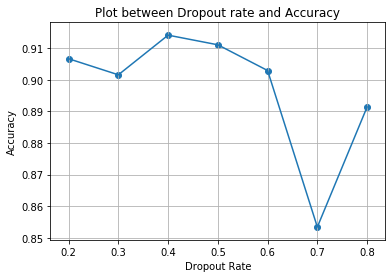

In [0]:
import matplotlib.pyplot as plt

plt.plot([0.2,0.3,0.4,0.5,0.6,0.7,0.8],Accuracy)
plt.scatter([0.2,0.3,0.4,0.5,0.6,0.7,0.8],Accuracy)
plt.title("Plot between Dropout rate and Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Dropout Rate")
plt.grid()
plt.show()

#Model with 2 LSTM layer and each LSTM layer contain 32 cells and keeping the dropout rate for both kayers is 0.4

In [0]:
model_0 = Sequential()
# Configuring the parameters
model_0.add(LSTM(32, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model_0.add(Dropout(0.4))
model_0.add(LSTM(32))
model_0.add(Dropout(0.4))
# Adding a dense output layer with sigmoid activation
model_0.add(Dense(n_classes, activation='softmax'))
model_0.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_4 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_0.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [0]:
model_0.fit(X_train,
          Y_train,
          batch_size=batch_size,
          
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 89s 12ms/step - loss: 1.1912 - acc: 0.5008 - val_loss: 1.0537 - val_acc: 0.5412
Epoch 2/30
7352/7352 [==============================] - 85s 12ms/step - loss: 0.6955 - acc: 0.7433 - val_loss: 0.5747 - val_acc: 0.8181
Epoch 3/30
7352/7352 [==============================] - 85s 12ms/step - loss: 0.3794 - acc: 0.8893 - val_loss: 0.5413 - val_acc: 0.8439
Epoch 4/30
7352/7352 [==============================] - 86s 12ms/step - loss: 0.2635 - acc: 0.9193 - val_loss: 0.5246 - val_acc: 0.8599
Epoch 5/30
7352/7352 [==============================] - 91s 12ms/step - loss: 0.2891 - acc: 0.9055 - val_loss: 0.4666 - val_acc: 0.8497
Epoch 6/30
7352/7352 [==============================] - 92s 12ms/step - loss: 0.2375 - acc: 0.9208 - val_loss: 0.6414 - val_acc: 0.7811
Epoch 7/30
7352/7352 [==============================] - 92s 12ms/step - loss: 0.2719 - acc: 0.9071 - val_loss: 0.4570 - val_acc: 0.8470


In [0]:
print(confusion_matrix(Y_test, model_0.predict(X_test)))

score = model_0.evaluate(X_test, Y_test)
print("Loss and Accuracy on test dataset.")
print("Loss =",score[0],"Accuracy =",score[1])

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 510        0  ...                   0                27
SITTING                  0      417  ...                   0                12
STANDING                 0      109  ...                   0                 3
WALKING                  0        0  ...                  34                 4
WALKING_DOWNSTAIRS       0        0  ...                 415                 2
WALKING_UPSTAIRS         0        2  ...                  11               453

[6 rows x 6 columns]
2947/2947 [==============================] - 12s 4ms/step
Loss and Accuracy on test dataset.
Loss = 0.3705637179395716 Accuracy = 0.9070240922972514


#Model with 2 LSTM layer and each layer contain 64 LSTM cells and dropout rate for both layer is 0.5

In [0]:
# Initiliazing the sequential model
model_5 = Sequential()
# Configuring the parameters
model_5.add(LSTM(64, input_shape=(timesteps, input_dim),return_sequences=True))
# Adding a dropout layer
model_5.add(Dropout(0.5))
#Adding another LSTM layer
model_5.add(LSTM(64))
#adding Dropout Layer
model_5.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model_5.add(Dense(n_classes, activation='softmax'))
model_5.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 64)           18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 52,358
Trainable params: 52,358
Non-trainable params: 0
_________________________________________________________________


In [0]:
model_5.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [0]:
model_5.fit(X_train,Y_train,verbose=1,batch_size=batch_size,epochs=50,validation_data=(X_test,Y_test))

Train on 7352 samples, validate on 2947 samples
Epoch 1/50
7352/7352 [==============================] - 90s 12ms/step - loss: 1.0967 - acc: 0.5325 - val_loss: 0.7467 - val_acc: 0.6916
Epoch 2/50
7352/7352 [==============================] - 88s 12ms/step - loss: 0.6820 - acc: 0.7088 - val_loss: 0.6000 - val_acc: 0.7662
Epoch 3/50
7352/7352 [==============================] - 90s 12ms/step - loss: 0.4985 - acc: 0.8047 - val_loss: 0.5971 - val_acc: 0.7367
Epoch 4/50
7352/7352 [==============================] - 89s 12ms/step - loss: 0.4451 - acc: 0.8048 - val_loss: 0.5267 - val_acc: 0.8093
Epoch 5/50
7352/7352 [==============================] - 86s 12ms/step - loss: 0.5469 - acc: 0.7885 - val_loss: 0.7265 - val_acc: 0.7228
Epoch 6/50
7352/7352 [==============================] - 85s 12ms/step - loss: 0.4018 - acc: 0.8576 - val_loss: 0.6966 - val_acc: 0.7648
Epoch 7/50
7352/7352 [==============================] - 85s 12ms/step - loss: 0.3235 - acc: 0.8938 - val_loss: 0.4196 - val_acc: 0.8599


In [0]:
score=model_5.evaluate(X_test,Y_test,verbose=0)
print("Loss =",score[0]," Accuracy =",score[1])

Loss = 0.25753965879978535  Accuracy = 0.9212758737699356


In [0]:
print(confusion_matrix(Y_test, model_5.predict(X_test)))

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  1      373  ...                   1                 2
STANDING                 0       71  ...                   0                 1
WALKING                  0        0  ...                   0                29
WALKING_DOWNSTAIRS       0        0  ...                 417                 2
WALKING_UPSTAIRS         0        0  ...                   6               461

[6 rows x 6 columns]


#=======================================================================

In [0]:
from prettytable import PrettyTable
import seaborn as sns
table=PrettyTable()
table.field_names=("M0del","Test Loss","Test Accuracy")

table.add_row(("Model-1",0.40,0.87))
table.add_row(("Model-2",0.49,0.87))
table.add_row(("Model-3",0.43,0.87))
table.add_row(("Model-4",0.38,0.90))
table.add_row(("Model-5 with 2 LSTM Layers and 32 cells each",0.37,0.90))
table.add_row(("Model-6 with 2 LSTM Layers and 64 cells each",0.25,0.92))
print(table)

+----------------------------------------------+-----------+---------------+
|                    M0del                     | Test Loss | Test Accuracy |
+----------------------------------------------+-----------+---------------+
|                   Model-1                    |    0.4    |      0.87     |
|                   Model-2                    |    0.49   |      0.87     |
|                   Model-3                    |    0.43   |      0.87     |
|                   Model-4                    |    0.25   |      0.92     |
| Model-5 with 2 LSTM Layers and 32 cells each |    0.37   |      0.9      |
| Model-6 with 2 LSTM Layers and 64 cells each |    0.36   |      0.9      |
+----------------------------------------------+-----------+---------------+
